# 1. Introduction

# 2. Import Library

In [1]:
# for data manipulation
import pandas as pd 
import numpy as np

# for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import STOPWORDS

# for model buidling
import tensorflow as tf
import tensorflow_hub as tf_hub
from scipy.sparse import csr_matrix

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from tensorflow.keras.utils import plot_model

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization, Embedding, Bidirectional, LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# for model evaluation
from sklearn.metrics import classification_report

# for text preprocess
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

# hide all warnings
import warnings
warnings.filterwarnings('ignore')

# show all columns
pd.options.display.max_columns = None

2024-07-02 17:49:33.804573: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nathanaelh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nathanaelh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 3. Data Loading 

In [2]:
data = pd.read_csv('data/consumer_complaints_labeled.csv')

In [3]:
data.head()

,sentence,light_complaints,harsh_complaints,mild_complaints
0,Can't stop charges to bank account Can't stop ...,0,1,1
1,Cont'd attempts collect debt not owed Debt is ...,0,0,1
2,Disclosure verification of debt Right to dispu...,0,0,1
3,Cont'd attempts collect debt not owed Debt is ...,0,1,1
4,Cont'd attempts collect debt not owed Debt is ...,1,1,0


# 4. Data Preprocessing

## a. Text Preprocessing

In [4]:
# Define Stopwords
stop_words = set(stopwords.words('english'))

# Define Stemming
lemmatizer = WordNetLemmatizer()

In [5]:
# Create A Function for Text Preprocessing
def text_preprocessing(text):
  # Case folding
  text = text.lower()

  # Mention removal
  text = re.sub("@[A-Za-z0-9_]+", " ", text)

  # Hashtags removal
  text = re.sub("#[A-Za-z0-9_]+", " ", text)

  # Newline removal (\n)
  text = re.sub(r"\\n", " ",text)

  # Whitespace removal
  text = text.strip()

  # URL removal
  text = re.sub(r"http\S+", " ", text)
  text = re.sub(r"www.\S+", " ", text)

  # Non-letter removal (such as emoticon, symbol (like μ, $, 兀), etc
  text = re.sub("[^A-Za-z\s']", " ", text)
  text = re.sub("'", "", text)

  # Tokenization
  tokens = word_tokenize(text)

  # Stopwords removal
  tokens = [word for word in tokens if word not in stop_words]

  # Stemming
  tokens = [lemmatizer.lemmatize(word) for word in tokens]

  # Combining Tokens
  text = " ".join(tokens)

  return text

In [6]:
data['sentence_processed'] = data['sentence'].apply(lambda x: text_preprocessing(x))
data

,sentence,light_complaints,harsh_complaints,mild_complaints,sentence_processed
0,Can't stop charges to bank account Can't stop ...,0,1,1,cant stop charge bank account cant stop charge...
1,Cont'd attempts collect debt not owed Debt is ...,0,0,1,contd attempt collect debt owed debt mine dent...
2,Disclosure verification of debt Right to dispu...,0,0,1,disclosure verification debt right dispute not...
3,Cont'd attempts collect debt not owed Debt is ...,0,1,1,contd attempt collect debt owed debt mine disp...
4,Cont'd attempts collect debt not owed Debt is ...,1,1,0,contd attempt collect debt owed debt mine reac...
...,...,...,...,...,...
2216,Disclosure verification of debt Not given enou...,0,1,1,disclosure verification debt given enough info...
2217,Cont'd attempts collect debt not owed Debt was...,0,0,1,contd attempt collect debt owed debt paid xxxx...
2218,Taking/threatening an illegal action Threatene...,0,1,0,taking threatening illegal action threatened a...
2219,False statements or representation Attempted t...,0,0,1,false statement representation attempted colle...


## b. Train Test Split

In [7]:
sentence = data['sentence_processed']

labels = data[['light_complaints', 'harsh_complaints', 'mild_complaints']]

In [8]:
# Data Splitting
X_train_val, X_test, y_train_val, y_test = train_test_split(sentence,
                                                    labels,
                                                    test_size=0.15,
                                                    random_state=20,
                                                    stratify=labels)

X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=0.10,
                                                  random_state=20,
                                                  stratify=y_train_val)

print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (1698,)
Val Size   :  (189,)
Test Size  :  (334,)


## c. Finding Number of Vocab and Max Token Lenght


In [9]:
# Vectorize Text
Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_val_vec = Vectorize.transform(X_val)
X_test_vec = Vectorize.transform(X_test)

# Show vectorized X_train
X_train_vec

<1698x6706 sparse matrix of type '<class 'numpy.int64'>'
	with 96817 stored elements in Compressed Sparse Row format>

In [10]:
# Finding the Number of Vocabs and Max Token Length in One Document
total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  6706
Maximum Sentence Length :  400 tokens


## d. Text Vectorization

In [11]:
# Text Vectorization
text_vectorization = TextVectorization(max_tokens=10000,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,)) # Only use in Sequential API

text_vectorization.adapt(X_train)

In [12]:
text_vectorization.get_vocabulary()[:20]

['',
 '[UNK]',
 'xxxx',
 'debt',
 'credit',
 'account',
 'collection',
 'call',
 'xx',
 'collect',
 'owed',
 'payment',
 'company',
 'attempt',
 'would',
 'received',
 'paid',
 'time',
 'report',
 'loan']

## e. Embedding

In [13]:
# Embedding
embedding = Embedding(input_dim=10000,
                      output_dim=128,
                      embeddings_initializer="uniform"
                      )

In [14]:
## Document example
print('Document example')
print(data.sentence_processed[0])
print('')

## Result of Text Vectorization
print('Result of Text Vectorization')
print(text_vectorization([data.sentence_processed[0]]))
print('Vector size : ', text_vectorization([data.sentence_processed[0]]).shape)

## Result of  Embedding
print('Result of  Embedding')
print(embedding(text_vectorization([data.sentence_processed[0]])))
print('Vector size : ', embedding(text_vectorization([data.sentence_processed[0]])).shape)

Document example
cant stop charge bank account cant stop charge bank account took loan cash central xxxx al sense time lost job also medication went roof unable pay loan back every sense time receiving phone call everyday day pas calling always call different number never know calling caused pay much money bank time bank xxxx xxxx xxxx al caused pay hundred dollar overdraft fee money could paid would stop trying debit account call every day starting around xxxx telling thing time call money pay money would pay month paid income increase able pay fix income pay tell pay nt know self tired harassing phone call xxxx xxxx every day get worse worse ca nt keep putting calling every day like work nerve set really bad told xxxx people call would try pay something next month screamed said next month next month told see bill would run could give amount much pay know even could pay would dollar much keep calling calling every day pas month ca nt take longer nerve bad run xxxx xxxx calling every d

# 5. Model Building

## a. Model Definition

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 400)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 400, 128)          1280000   
                                                                 
 lstm (LSTM)                 (None, 400, 32)           20608     
                                                                 
 lstm_1 (LSTM)               (None, 400, 16)           3136      
                                                                 
 lstm_2 (LSTM)               (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 3)                 27        
                                                        

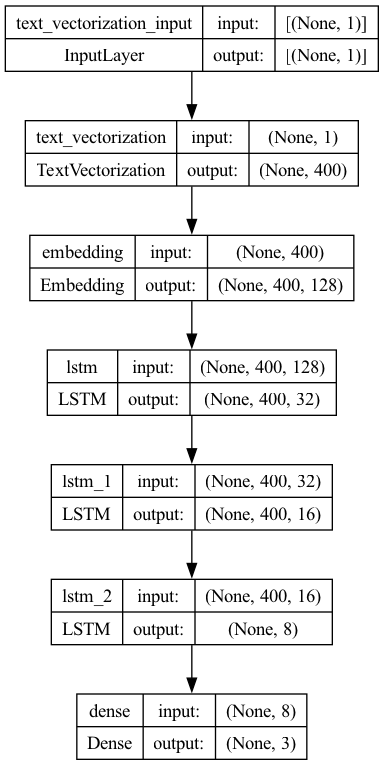

In [15]:
## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Define the architecture
model_lstm_1 = Sequential()
model_lstm_1.add(text_vectorization)
model_lstm_1.add(embedding)
model_lstm_1.add(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed)))  
model_lstm_1.add(LSTM(16, return_sequences=True))  # Avoiding custom initializers for compatibility
model_lstm_1.add(LSTM(8))
model_lstm_1.add(Dense(3, activation='sigmoid'))

# Ensure loss function is correct
model_lstm_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_lstm_1.summary()

# plot the model
plot_model(model_lstm_1, show_shapes=True, show_layer_names=True)

## b. Model Training

In [16]:
# Assign callback to speed up computing and reduce learning rate
callbacks= [
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        verbose=0,
        restore_best_weights=True
        ),
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.01,
        patience=2
        )
]

In [17]:
# model training
model_lstm_1_hist = model_lstm_1.fit(X_train,
                                     y_train,
                                     epochs=25,
                                     batch_size=32,
                                     validation_data=(X_val, y_val),
                                     callbacks=callbacks)

Epoch 1/25
54/54 [==============================] - 17s 234ms/step - loss: 0.5725 - accuracy: 0.4317 - val_loss: 0.5216 - val_accuracy: 0.4339 - lr: 0.0010
Epoch 2/25
54/54 [==============================] - 12s 230ms/step - loss: 0.5181 - accuracy: 0.4352 - val_loss: 0.5197 - val_accuracy: 0.4339 - lr: 0.0010
Epoch 3/25
54/54 [==============================] - 13s 238ms/step - loss: 0.5173 - accuracy: 0.4352 - val_loss: 0.5195 - val_accuracy: 0.4339 - lr: 0.0010
Epoch 4/25
54/54 [==============================] - 13s 250ms/step - loss: 0.5169 - accuracy: 0.4352 - val_loss: 0.5195 - val_accuracy: 0.4339 - lr: 1.0000e-05
Epoch 5/25
54/54 [==============================] - 14s 265ms/step - loss: 0.5169 - accuracy: 0.4352 - val_loss: 0.5195 - val_accuracy: 0.4339 - lr: 1.0000e-05
Epoch 6/25
54/54 [==============================] - 15s 283ms/step - loss: 0.5169 - accuracy: 0.4352 - val_loss: 0.5195 - val_accuracy: 0.4339 - lr: 1.0000e-07


## c. Model Evaluation

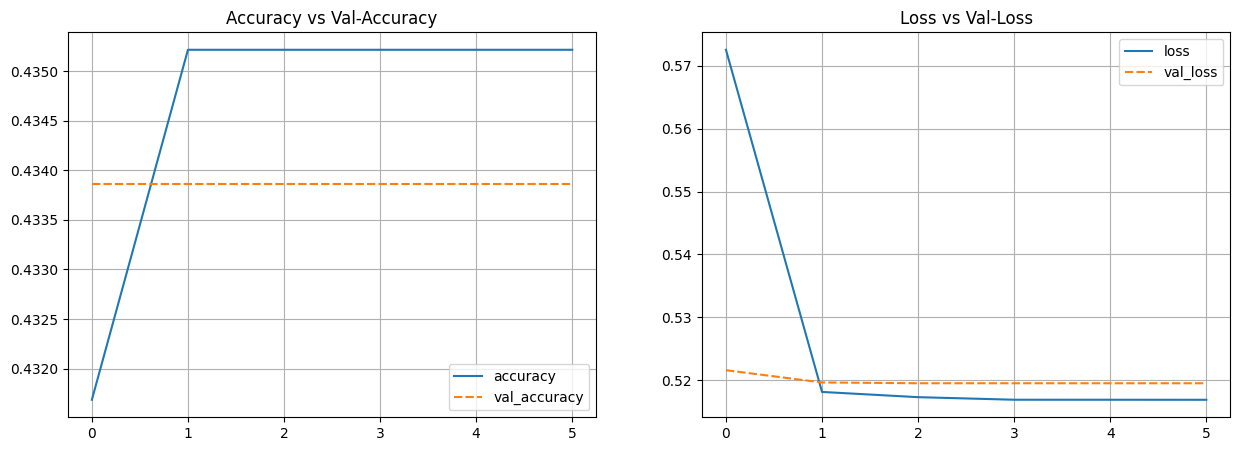

In [18]:
# Plot Training Results
model_lstm_1_hist_df = pd.DataFrame(model_lstm_1_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_1_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_1_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.show()

In [19]:
# Predict and evaluate model 1
y_pred = model_lstm_1.predict(X_test)
# y_pred_biner_1 = tf.where(y_pred_proba_1 >= 0.5, 1, 0)

y_pred[:,0] = tf.where(y_pred[:,0] > 0.1, 1, 0)  # Thresholding light complaints at 0.1
y_pred[:,1] = tf.where(y_pred[:,1] > 0.1, 1, 0)  # Thresholding harsh complaints at 0.1
y_pred[:,2] = tf.where(y_pred[:,2] > 0.75, 1, 0)  # Thresholding mild complaints at 0.75

report_1 = classification_report(y_test, y_pred, target_names=['light', 'harsh', 'mild'])

test_loss_1, test_accuracy_1 = model_lstm_1.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss_1}")
print(f"Test Accuracy: {test_accuracy_1}")
print(report_1)

11/11 [==============================] - 1s 61ms/step - loss: 0.5196 - accuracy: 0.4341
Test Loss: 0.5196250677108765
Test Accuracy: 0.4341317415237427
              precision    recall  f1-score   support

       light       0.19      1.00      0.32        64
       harsh       0.47      1.00      0.64       156
        mild       0.88      1.00      0.93       293

   micro avg       0.51      1.00      0.68       513
   macro avg       0.51      1.00      0.63       513
weighted avg       0.67      1.00      0.77       513
 samples avg       0.51      1.00      0.66       513



## d. Model Improvements

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 400)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 400, 128)          1280000   
                                                                 
 bidirectional (Bidirection  (None, 400, 128)          98816     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                        

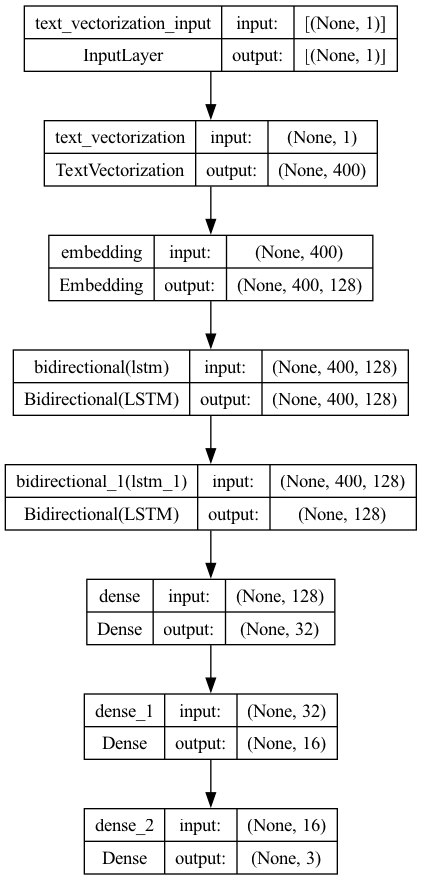

In [25]:
## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_lstm_2 = Sequential()
model_lstm_2.add(text_vectorization)
model_lstm_2.add(embedding)
model_lstm_2.add(Bidirectional(LSTM(64, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Bidirectional(LSTM(64, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dense(32, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed)))
model_lstm_2.add(Dense(16, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed)))
model_lstm_2.add(Dense(3, activation='sigmoid'))

# Ensure loss function is correct
model_lstm_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_lstm_2.summary()

# plot the model
plot_model(model_lstm_2, show_shapes=True, show_layer_names=True)

In [26]:
# Assign callback to speed up computing and reduce learning rate
callbacks= [
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        verbose=0,
        restore_best_weights=True
        ),
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.01,
        patience=2
        )
]

In [27]:
# model training
model_lstm_2_hist = model_lstm_2.fit(X_train,
                                     y_train,
                                     epochs=25,
                                     batch_size=32,
                                     validation_data=(X_val, y_val),
                                     callbacks=callbacks)

Epoch 1/25
54/54 [==============================] - 48s 780ms/step - loss: 0.4755 - accuracy: 0.4823 - val_loss: 0.4058 - val_accuracy: 0.5291 - lr: 0.0010
Epoch 2/25
54/54 [==============================] - 38s 702ms/step - loss: 0.3494 - accuracy: 0.5895 - val_loss: 0.3811 - val_accuracy: 0.5291 - lr: 0.0010
Epoch 3/25
54/54 [==============================] - 38s 706ms/step - loss: 0.2614 - accuracy: 0.5913 - val_loss: 0.3964 - val_accuracy: 0.5132 - lr: 0.0010
Epoch 4/25
54/54 [==============================] - 40s 743ms/step - loss: 0.2013 - accuracy: 0.5430 - val_loss: 0.3891 - val_accuracy: 0.5185 - lr: 1.0000e-05
Epoch 5/25
54/54 [==============================] - 38s 708ms/step - loss: 0.1914 - accuracy: 0.5559 - val_loss: 0.3866 - val_accuracy: 0.5185 - lr: 1.0000e-05
Epoch 6/25
54/54 [==============================] - 43s 807ms/step - loss: 0.1872 - accuracy: 0.5589 - val_loss: 0.3866 - val_accuracy: 0.5185 - lr: 1.0000e-07


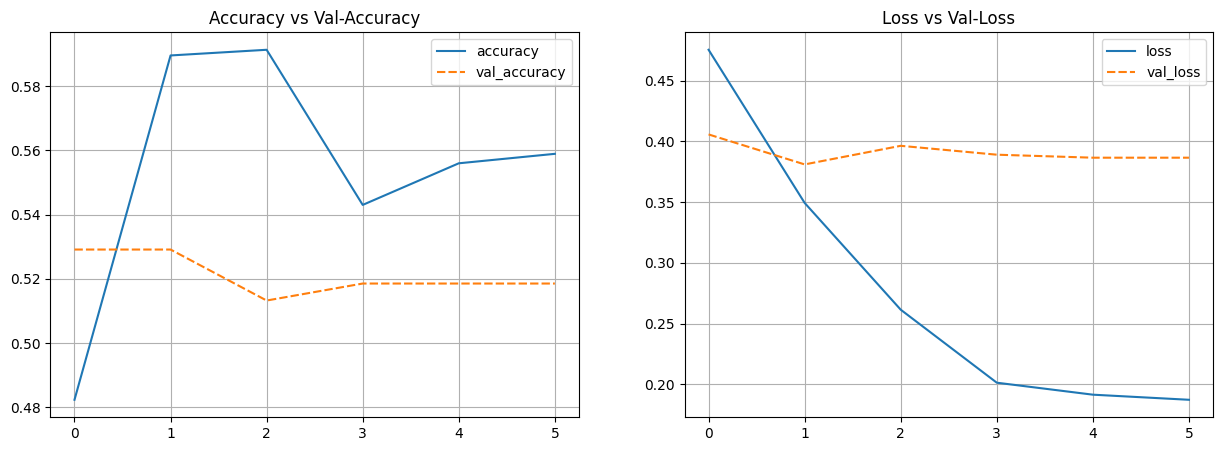

In [28]:
# Plot Training Results
model_lstm_2_hist_df = pd.DataFrame(model_lstm_2_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_2_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_2_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.show()

In [29]:
# Predict and evaluate model 1
y_pred = model_lstm_2.predict(X_test)
# y_pred_biner_2 = tf.where(y_pred_proba_2 >= 0.5, 1, 0)

y_pred[:,0] = tf.where(y_pred[:,0] > 0.1, 1, 0)  # Thresholding light complaints at 0.1
y_pred[:,1] = tf.where(y_pred[:,1] > 0.1, 1, 0)  # Thresholding harsh complaints at 0.1
y_pred[:,2] = tf.where(y_pred[:,2] > 0.75, 1, 0)  # Thresholding mild complaints at 0.75

report_2 = classification_report(y_test, y_pred, target_names=['light', 'harsh', 'mild'])

test_loss_2, test_accuracy_2 = model_lstm_2.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss_2}")
print(f"Test Accuracy: {test_accuracy_2}")
print(report_2)

11/11 [==============================] - 5s 443ms/step - loss: 0.4083 - accuracy: 0.5419
Test Loss: 0.4082678258419037
Test Accuracy: 0.5419161915779114
              precision    recall  f1-score   support

       light       0.23      0.88      0.36        64
       harsh       0.47      1.00      0.64       156
        mild       0.96      0.92      0.94       293

   micro avg       0.56      0.94      0.70       513
   macro avg       0.55      0.93      0.65       513
weighted avg       0.72      0.94      0.78       513
 samples avg       0.57      0.95      0.69       513



# 6. Model Saving 

In [30]:
model_lstm_2.save('model.keras')